# **CSC 84030: Big Data Analytics- Hw3 [35 +2 points]**
# **Natural Language Processing Using Bloom Filters and LSH**
# **Due: Nov 17th 11:59 pm**
#### This homework will give you some hands-on experience in using Bloom Filters for streaming application and using MinHASH-LSH for topic grouping. Bloom Filters are typically used for streaming sources. As setting up a streaming data source involves some complexities, instead we will work with Bloom Filters using DataFrames from the Yelp dataset we used in P2.


### 1. Setup

 We will install spark, the open source [bloom_filter](https://github.com/hiway/python-bloom-filter) implementation, and [NLTK Corpus](https://www.nltk.org/api/nltk.corpus.html). Run the cells below to install the required libraries and set up the environment.

In [ ]:
!pip install pyspark
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Spark Bloom Filters").getOrCreate()

In [ ]:
!pip install bloom_filter

In [ ]:
!pip install nltk

### 2. Data Loading


We will use two data sources:
- The Yelp Dataset we worked on in P2
- NLTK corpora collection that has curated information such as words, opinions (positive, negative), movie review, etc.

We will start by filtering the Yelp Business DataFrame and retain only businesses with more than 3000 reviews. Following this, we will join with the reviews DataFrame and obtain the corresponding review. ***Running the next three cells will create a new DataFrame yelp_reviews_filtered which will contain all the reviews of the businesses with more than 3000 reviews***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
yelp_bussiness_df=spark.read.json('/content/drive/MyDrive/Yelp_dataset/yelp_academic_dataset_business.json')
yelp_bussiness_df.printSchema()


root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [ ]:
yelp_bussiness_df_filtered=yelp_bussiness_df.select('*').where((yelp_bussiness_df["review_count"].isNotNull())& (yelp_bussiness_df["review_count"]>3000))
print(yelp_bussiness_df_filtered.count())

27


In [ ]:

yelp_reviews_df=spark.read.json("/content/drive/MyDrive/Yelp_dataset/yelp_academic_dataset_review.json")
yelp_reviews_filtered=yelp_bussiness_df_filtered.join(yelp_reviews_df,yelp_bussiness_df_filtered.business_id==yelp_reviews_df.business_id).select(yelp_reviews_df.business_id,yelp_reviews_df.user_id,yelp_reviews_df.text)
print(yelp_reviews_filtered.count())

118576


In [ ]:
yelp_reviews_filtered.show(5,truncate=False)

+----------------------+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**[5 points] TASK-1**

Your first task is to tokenize the review which are present as single string in the column *text* in the yelp_reviews_filtered DataFrame. Your task is to convert the text into words. For this you will use ***Tokenizer*** from spark ML.
- Create a new DataFrame by name *tokenized_reviews*
- The DataFrame should include a new column called ***words*** of ArrayType which contains the list of words in the review for each row

In [ ]:
from pyspark.ml.feature import Tokenizer
#YOUR CODE HERE

tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_reviews=tokenizer.transform(yelp_reviews_filtered)

In [ ]:
if tokenized_reviews is not None:
  print(tokenized_reviews.show(5,truncate=False))

+----------------------+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

We will import two corpuses from NLTK:
- Words: This contains more than two hundred thousand English words, we will use this for spell checking.
- Opinion Lexicon: This corpus contains two sets of words. One positive_lexicon, contains the words indicating positive sentiments and negative_lexicon contains words suggesting negative senteiments. We will use this for sentiment analysis.


In [ ]:
import nltk
nltk.download('words')
from nltk.corpus import words
word_list = words.words()
print(f'Dictionary length: {len(word_list)}')
print(word_list[:15])

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Dictionary length: 236736
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru']


In [ ]:
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')
positive_word_list=opinion_lexicon.positive()
negative_word_list=opinion_lexicon.negative()
print("The number of positive words: {}".format(len(positive_word_list)))
print("The number of negative words: {}".format(len(negative_word_list)))

The number of positive words: 2006
The number of negative words: 4783


[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


###3. Filters and Functions

Our spell checkers and setiment analysis will be based on Bloom Filters.

**[5 points] Task-2** You will create three Bloom Filters
- word_filter : This filter will be based on the word_list and be used for spell checking.
- positive_sentiment_filter: This filter will be based on positive_word_list and be used for inferring the positivity in the review.
- negative sentiment_Filter: This will be based on negative_word_list and be used for inferring the negativity in the review.

To figure out how to create the Bloom Filters, please refer to the original [documentation](https://github.com/hiway/python-bloom-filter).

In [ ]:
#YOUR CODE HERE
from bloom_filter import BloomFilter

#word bloom filter
word_filter = BloomFilter(max_elements=len(word_list))
for word in word_list:
  word_filter.add(word)

for word in word_list:
  assert word in word_filter

print("Assertions passed")

#positive sentiment bloom filter
positive_sentiment_filter=BloomFilter(max_elements=len(positive_word_list))
for word in positive_word_list:
  positive_sentiment_filter.add(word)

for word in positive_word_list:
  assert word in positive_sentiment_filter

print("Assertions passed")

#negative sentiment bloom filter
negative_sentiment_Filter=BloomFilter(max_elements=len(negative_word_list))
for word in negative_word_list:
  negative_sentiment_Filter.add(word)

for word in negative_word_list:
  assert word in negative_sentiment_Filter

print("Assertions passed")

Assertions passed
Assertions passed
Assertions passed


**[6 Points] Task-3:** We will next create three functions, each function will take a list as input and return an integer.
- check_typos_in_list: This function will take in a list of words and use the word_filter to find the number of words with typos and return their count
- check_positives_in_list: This function will take in a list of words and use the positive_sentiment_filter to find the number of words that are postive and return their count
- check_negatives_in_list: This function will take in a list of words and use the negative_sentiment_filter to find the number of words that are negative and return their count

***Hint:*** You might want to attend to empty strings.

In [ ]:

def check_typos_in_list(words):
  """
  returns number of typos as an integer
  """
  typos=0
  for word in words:
    if word and word not in word_filter:
      typos+=1
  return typos

def check_positives_in_list(words):
  """
  returns number of positive words as an integer
  """
  # YOUR CODE HERE
  positive=0
  for word in words:
    if word and word in positive_sentiment_filter:
      positive+=1
  return positive

def check_negatives_in_list(words):
  """
  returns number of negative words as an integer
  """
  # YOUR CODE HERE
  negative=0
  for word in words:
    if word and word in negative_sentiment_Filter:
      negative+=1
  return negative

**[3 points] Task-4:** We will next define three user defined functions (UDF) for the three filter functions we have created. To get to know how to define and register user defined functions in Pyspark, please follow this [tutorial.](https://docs.databricks.com/en/udf/python.html) You can use the the following names to create the functions and their corresponding UDF.

- Function name: check_typos_in_list UDF: spell_checker_udf
- Function name: check_positives_in_list: UDF: positive_sentiment_udf
- Function name: check_negatives_in_list UDF: negative_sentiment_udf

**[3 points] Task-5** Apply each of the user defined functions to the tokenized_reviews DataFrame. In the end the tokenized_reviews DataFrame should have three new columns:
  - typos: This should contain the number of typos
  - positive_sentiment - The number of words that are filtered positive
  - negative sentiment - The number of words that are filtered negative

In [ ]:
# YOUR CODE HERE
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType

spell_checker_udf = udf(check_typos_in_list,LongType())
positive_sentiment_udf = udf(check_positives_in_list,LongType())
negative_sentiment_udf = udf(check_negatives_in_list,LongType())

#apply udf
typo_df=tokenized_reviews.withColumn("typos", spell_checker_udf(tokenized_reviews['words']))
positive_df=typo_df.withColumn("positive_sentiment", positive_sentiment_udf(tokenized_reviews['words']))
tokenized_reviews=positive_df.withColumn("negative sentiment", negative_sentiment_udf(tokenized_reviews['words']))

tokenized_reviews.show()

+--------------------+--------------------+--------------------+--------------------+-----+------------------+------------------+
|         business_id|             user_id|                text|               words|typos|positive_sentiment|negative sentiment|
+--------------------+--------------------+--------------------+--------------------+-----+------------------+------------------+
|GBTPC53ZrG1ZBY3DT...|pitYOVSsF8R1gWG1G...|We have been here...|[we, have, been, ...|    6|                 4|                 7|
|GBTPC53ZrG1ZBY3DT...|VMtyZjaEJB9nfmjr4...|First meal in New...|[first, meal, in,...|   26|                14|                 9|
|GBTPC53ZrG1ZBY3DT...|0WqEkKMu03irkMiEt...|Service is excell...|[service, is, exc...|   43|                39|                31|
|GBTPC53ZrG1ZBY3DT...|tt2qIFKZumubxk_Uw...|This was our seco...|[this, was, our, ...|   29|                22|                19|
|GBTPC53ZrG1ZBY3DT...|XuadFePn8P6l5epbE...|Great oyster happ...|[great, oyster, h...|   16

##4. Analysis

We will first study the impact of the False Positive rate on the Bloom Filters. Remember, the False positive Rate is controlled by the number of hash functions you use. The way to controll this parameter in the Bloom Filter library we are using the arugment error_rate. We will see the impact of different error rates for the sentiment analysis. As running this experiment for the all the rows could take time, we will instead run them on a subset. I have retained 1000 rows in the *tokenized_reviews_subset* DataFrame. Feel free to increase the number as you see fit. You will use this DataFrame for all the analysis that follow.

**[3 Points Taks-5]** Change the error rates for the Bloom Filter and observe the variation in the number of positive words in the subset of the Data Frame selected. *You will have to redeclare the UDF each time you create a new Bloom Filter.* If you do not redeclare this after the creation of the new filter, the previous version of the filter will be used in your UDF.

- You will vary the error rate from 0 to 0.9 in the incrementes of 0.1 and create a plot. The X-axis of the plot should contain the error rate and Y-axis the number of Typos. Although, we do not know the ground truth we just want to see how the filter reacts to varying error rates.

- **[2 Points Extra Credit]** In addition you can also compare the runtime for different error rates. You can use the Python's time library to do this. This will be another plot show how the run time changes with respect to the error rate.


In [ ]:
if tokenized_reviews is not None:
  tokenized_reviews_subset = tokenized_reviews.limit(1000)
  tokenized_reviews_subset.persist()
  print(tokenized_reviews_subset.count())


1000


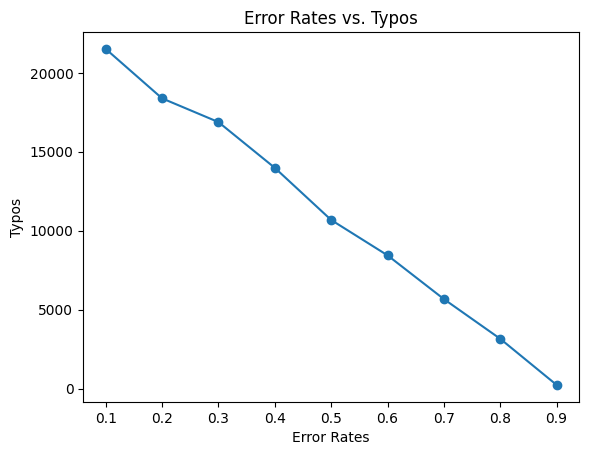

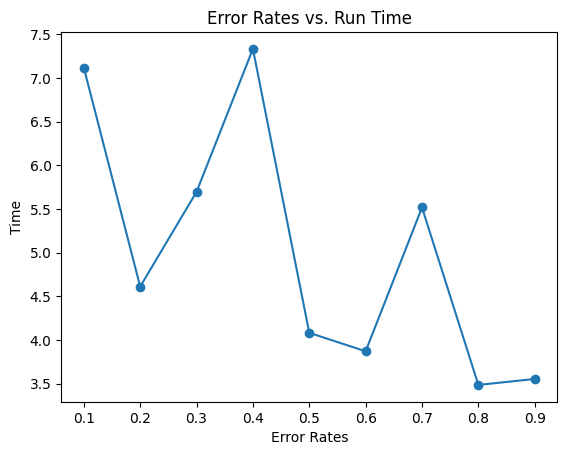

In [ ]:
# YOUR CODE HERE
import time
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum as _sum

rates=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
times=[]
typos=[]

for rate in rates:
  start_time = time.time()
  #set bloom filter for different error rates
  word_filter=BloomFilter(max_elements=len(word_list), error_rate=rate)
  for word in word_list:
    word_filter.add(word)
  #count the typos per row
  spell_checker_udf=udf(check_typos_in_list, LongType())
  typo_df=tokenized_reviews_subset.withColumn("typos", spell_checker_udf(tokenized_reviews_subset['words']))
  typos.append(typo_df.select(_sum("typos")).collect()[0][0]) #sum the number of typos
  end_time = time.time()
  diff = end_time-start_time
  times.append(diff)

#plotting typos
plt.plot(rates, typos, marker='o')
plt.title('Error Rates vs. Typos')
plt.xlabel('Error Rates')
plt.ylabel('Typos')
plt.show()

#plotting runtime
plt.plot(rates, times, marker='o')
plt.title('Error Rates vs. Run Time')
plt.xlabel('Error Rates')
plt.ylabel('Time')
plt.show()

**[2 Points Task-6]**

You will build a simple classifier which will classify a review as Positive or negative. The classification will be based on the number of positive words and negative words. Your classifier should have the following behavior:
 - Count(Positive Words) > Count (Negative Words) - Positive
 - Count(Positive Words) <= Count (Negative Words) - Negative

This analysis will be based on the *tokenized_reviews_subset* which means you do not have to re do the filters again. The classification should be stored in a new column named *"Predictions"* and the results of this classification should be stored in a DataFrame *reviews_subset_classified*.

In [ ]:
#FILL IN
from pyspark.sql.functions import when, col

reviews_subset_classified=tokenized_reviews_subset.withColumn("Predictions",
                                                              when(col("positive_sentiment")>col("negative sentiment"),"Positive")
                                                              .otherwise("Negative"))
reviews_subset_classified.show()

+--------------------+--------------------+--------------------+--------------------+-----+------------------+------------------+-----------+
|         business_id|             user_id|                text|               words|typos|positive_sentiment|negative sentiment|Predictions|
+--------------------+--------------------+--------------------+--------------------+-----+------------------+------------------+-----------+
|GBTPC53ZrG1ZBY3DT...|pitYOVSsF8R1gWG1G...|We have been here...|[we, have, been, ...|    6|                 4|                 7|   Negative|
|GBTPC53ZrG1ZBY3DT...|VMtyZjaEJB9nfmjr4...|First meal in New...|[first, meal, in,...|   26|                14|                 9|   Positive|
|GBTPC53ZrG1ZBY3DT...|0WqEkKMu03irkMiEt...|Service is excell...|[service, is, exc...|   43|                39|                31|   Positive|
|GBTPC53ZrG1ZBY3DT...|tt2qIFKZumubxk_Uw...|This was our seco...|[this, was, our, ...|   29|                22|                19|   Positive|
|GBTPC

# [8 Points Task-6]

The final task is to use MinHashLSH to find simalirities between the reviews. For this you will use PySpark's MinHashLSH and compute pairwise similarities between all pairs tokenized reviews. This task is left openended for you to explore. As part of the task you are required to briefly comment on the observations on how the distance values varies with the number of hash tables used. You can plot this as a graph.

For this task you will use the *tokenized_reviews_subset* DataFrame.

Number of Hash Tables 3
+--------------------+--------------------+------------------+
|            datasetA|            datasetB|   JaccardDistance|
+--------------------+--------------------+------------------+
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...|               0.0|
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...| 0.864406779661017|
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...|0.8852459016393442|
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...|0.9495798319327731|
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...|0.8896551724137931|
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...| 0.897196261682243|
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...|0.8782608695652174|
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...|0.9270833333333334|
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...|0.8823529411764706|
|{GBTPC53ZrG1ZBY3D...|{GBTPC53ZrG1ZBY3D...|            0.8625|
+--------------------+--------------------+------------------+
only showing top 10 rows

Number of Hash Tables 7
+--------------------+--------------------+-

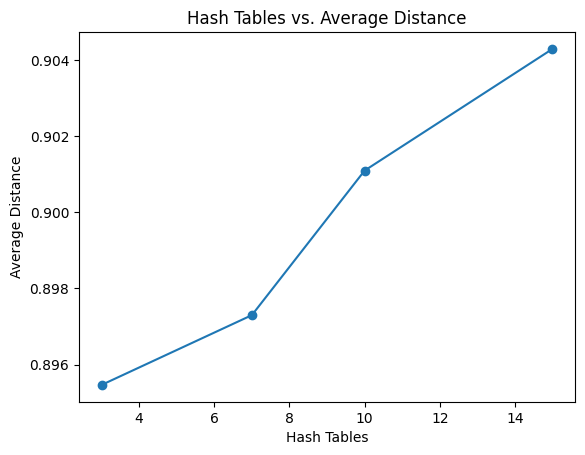

In [ ]:
#FILL IN
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import MinHashLSH

#vectorize tokens in subset
cv=CountVectorizer(inputCol="words", outputCol="vectors")
model=cv.fit(tokenized_reviews_subset)
vector_df=model.transform(tokenized_reviews_subset)

hashes=[3,7,10,15]
distances=[]

for num in hashes:
  #MinHashLSH
  mh=MinHashLSH(inputCol="vectors", outputCol="hashes", numHashTables=num)
  model2=mh.fit(vector_df)
  hashed_df=model2.transform(vector_df)

  similarity_df=model2.approxSimilarityJoin(vector_df,vector_df,1,distCol='JaccardDistance') #calculate similarities
  avg_distance = similarity_df.filter(similarity_df.datasetA>similarity_df.datasetB).select("JaccardDistance").agg({"JaccardDistance": "avg"}).collect()[0][0] #filter to avoid symmetry,
  distances.append(avg_distance)

  #print similarities
  print("Number of Hash Tables", num)
  similarity_df.show(10)

#plotting distances
plt.plot(hashes, distances, marker='o')
plt.title('Hash Tables vs. Average Distance')
plt.xlabel('Hash Tables')
plt.ylabel('Average Distance')
plt.show()

As the number of hash tables increase, the average jaccard distance increase as the number of hash tables increase. This noticable in both the graph and the tables as most of the similarties increase from increasing the hash tables. This implies that either detection of similarity improves as the number of hash tables increase.

#### **Submission Intruction:**

#### Click File -> Download -> Download **.ipynb**, and upload the downloaded file to Blackboard.